In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, precision_score, recall_score,
    confusion_matrix)
import seaborn as sns
import matplotlib.pyplot as plt

/home/artur/.local/lib/python3.11/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# === 1. Carregar dados e limpar
df_fake = pd.read_csv("Data/Fake.csv")
df_true = pd.read_csv("Data/True.csv")

df_fake['label'] = 0
df_true['label'] = 1

df_fake.drop(columns=["title", "date", "subject"], inplace=True, errors='ignore')
df_true.drop(columns=["title", "date", "subject"], inplace=True, errors='ignore')

def limpar_prefixo_agencia(texto):
    return re.sub(r"^(.*?\(Reuters\)[\s\-–]*)", "", texto)

df_true['text'] = df_true['text'].apply(limpar_prefixo_agencia)

df = pd.concat([df_fake, df_true], ignore_index=True)
df = df.drop_duplicates(subset='text').sample(frac=1, random_state=42).reset_index(drop=True)
df['input'] = df['text']

In [3]:
# === 2. Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    df['input'], df['label'], test_size=0.2, stratify=df['label'], random_state=42
)

In [4]:
# === 3. Vetorização TF-IDF
vectorizer = TfidfVectorizer(
    stop_words=None, max_features=20000, max_df=0.75, min_df=2, ngram_range=(1, 2)
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


In [5]:
# === 4. Modelo e validação cruzada
model = LogisticRegression(
    C=100, class_weight="balanced", penalty="l2", solver="liblinear", max_iter=1000
)

scoring = {'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc'}
cv_results = cross_validate(model, X_train_vec, y_train, cv=5, scoring=scoring)

print(" 5-Fold Cross-Validation Results:")
print(f"Accuracy (mean): {cv_results['test_accuracy'].mean():.4f}")
print(f"F1-score (mean): {cv_results['test_f1'].mean():.4f}")
print(f"ROC AUC (mean): {cv_results['test_roc_auc'].mean():.4f}")

 5-Fold Cross-Validation Results:
Accuracy (mean): 0.9897
F1-score (mean): 0.9907
ROC AUC (mean): 0.9989


In [6]:
# === 5. Treino final no treino completo
model.fit(X_train_vec, y_train)

# === 6. Avaliação no conjunto de teste
y_test_pred = model.predict(X_test_vec)
y_test_prob = model.predict_proba(X_test_vec)[:, 1]

test_acc = accuracy_score(y_test, y_test_pred)
test_prec = precision_score(y_test, y_test_pred)
test_rec = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_roc = roc_auc_score(y_test, y_test_prob)

print("\n Test Set Results:")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall:    {test_rec:.4f}")
print(f"F1-score:  {test_f1:.4f}")
print(f"ROC AUC:   {test_roc:.4f}")


 Test Set Results:
Accuracy:  0.9911
Precision: 0.9904
Recall:    0.9934
F1-score:  0.9919
ROC AUC:   0.9992


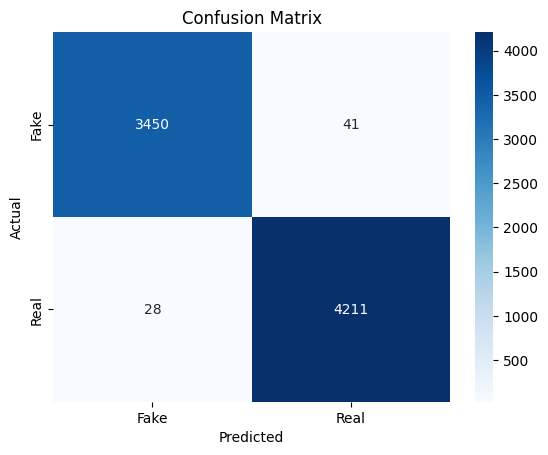

In [ ]:
# === 7. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()